In [178]:
import pandas as pd
from tqdm import tqdm
import glob
import re
tqdm.pandas()

In [179]:
df = pd.read_csv("train.csv")

In [180]:

def make_data(df):
    x={"id":[],"text":[],"discourse_area":[],"discourse_text":[],"discourse_type":[]}
    
    t=-1
    for a,b,c,d,e in zip(tqdm(df["id"]),df["discourse_start"],df["discourse_end"],df["discourse_text"],df["discourse_type"]):
        if a not in x["id"]:
            f = open(f"train/{a}.txt", 'r')
            sentence = f.read()
            if bool(re.search(r"\.\s",sentence)):
                t+=1
                x["id"].append(a)
                x["text"].append(sentence)
                x["discourse_area"].append([[b,c]])
                x["discourse_text"].append([d])
                x["discourse_type"].append([e])
        else:
            x["discourse_area"][t].append([b,c])
            x["discourse_text"][t].append(d)
            x["discourse_type"][t].append(e)
    return x

In [181]:
x=make_data(df)

100%|██████████| 144293/144293 [00:18<00:00, 7768.04it/s]


In [182]:
df=pd.DataFrame(x)

In [183]:
def split_data(df):
    x={"id":[],"text":[],"discourse_text":[],"discourse_type":[]}
    t=-1
    for  id_, text_, discourse_areas, discourse_texts, discourse_types in zip(tqdm(df["id"]),df["text"],df["discourse_area"],df["discourse_text"],df["discourse_type"]):
        for  discourse_area, discourse_text, discourse_type in zip(discourse_areas, discourse_texts, discourse_types):
            discourse_area=list(map(int, discourse_area))
            if id_ not in x["id"]:
                t+=1
                x["id"].append(id_)
                x["text"].append(text_)
                x["discourse_text"].append([text_[discourse_area[0]:discourse_area[1]]])
                x["discourse_type"].append([discourse_type])
                pre_text_index = discourse_area[1]
            else:
                if pre_text_index!=discourse_area[0]:
                    x["discourse_text"][t].append(text_[pre_text_index:discourse_area[0]])
                    x["discourse_type"][t].append("Nothing")
                x["discourse_text"][t].append(text_[discourse_area[0]:discourse_area[1]])
                x["discourse_type"][t].append(discourse_type)
                pre_text_index = discourse_area[1]
    return x

In [262]:
df_o=pd.DataFrame(split_data(df))

100%|██████████| 15575/15575 [00:14<00:00, 1040.49it/s]


In [261]:
def preprocess(text):
    text = re.sub("https?://[\w!\?/\+\-_~=;\.,\*&@#\$%\(\)'\[\]]+", ' ', text)
    text = re.sub('\(.*?\)',' ',text)
    text = re.sub('\s',' ',text)
    pattern = re.compile(r"(\d+),(\d+)")
    text = pattern.sub(r'\1\2',text)
    text = re.sub("’","'",text)
    text = re.sub(r"[^A-z0-9.,?!/&%$']",' ',text)
    text = re.sub(",",' , ',text)
    text = re.sub("!",'. ',text)
    text = re.sub("\s+",' ',text)
    x=text.split(".")
    y=[]
    for i,j in enumerate(x):
        if (bool(re.search("\s",j)) and len(j)>=4) or (i==0) or (j=="") or (j==" "):
            y.append(j)
        else:
            y[-1]+=j
    text = ".".join(y)
    pattern = re.compile(r"\.\s*([A-Z])")
    text = pattern.sub(r'. \1',text)
    pattern = re.compile(r"\?\s*([A-Z])")
    text = pattern.sub(r'? \1',text)
    text = re.sub(r"[\s]*\.[\.\s]+",". ",text)
    text = re.sub("' ","'",text)
    text = re.sub(" ,\s*",", ",text)
    text = re.sub(" \.",". ",text)
    text = text.lower()
    if len(text)>0:
        if text[-1]==".":
            text+=" "
    return text

def all_preprocess(text):
    if type(text)==str:
        return preprocess(text)
    
    else:
        return [preprocess(i) for i in text]

In [263]:
df_o["discourse_text"]=df_o["discourse_text"].progress_map(lambda x: all_preprocess(x))

100%|██████████| 15575/15575 [00:10<00:00, 1493.83it/s]


In [269]:
df_o

,id,text,discourse_text,discourse_type
0,423A1CA112E2,Phones\n\nModern humans today are always on th...,[modern humans today are always on their phone...,"[Lead, Nothing, Position, Nothing, Evidence, N..."
1,A8445CABFECE,Phones & Driving\n\nDrivers should not be able...,[drivers should not be able to use phones whil...,"[Position, Nothing, Claim, Nothing, Evidence, ..."
2,6B4F7A0165B9,Cell Phone Operation While Driving\n\nThe abil...,[the ability to stay connected to people we kn...,"[Lead, Nothing, Position, Nothing, Claim, Noth..."
3,E05C7F5C1156,People are debating whether if drivers should ...,[people are debating whether if drivers should...,"[Lead, Position, Nothing, Claim, Nothing, Clai..."
4,50B3435E475B,Texting and driving\n\nOver half of drivers in...,[over half of drivers in today's society have ...,"[Lead, Nothing, Position, Nothing, Claim, Noth..."
...,...,...,...,...
15570,8F4B595CF9E7,Do you ever want more opinions and options whe...,[do you ever want more opinions and options wh...,"[Lead, Position, Nothing, Claim, Nothing, Clai..."
15571,6B5809C83978,Has anyone ever gave you advice? Was the advic...,[has anyone ever gave you advice? was the advi...,"[Lead, Position, Nothing, Claim, Claim, Nothin..."
15572,408A7D3D2EEC,Imagine seeking advice from multiple people an...,[imagine seeking advice from multiple people a...,"[Lead, Nothing, Position, Nothing, Claim, Noth..."
15573,AFEC37C2D43F,There has been at least one point in everyone'...,[there has been at least one point in everyone...,"[Lead, Nothing, Position, Nothing, Claim, Noth..."


In [278]:
def delete_muda(df):
    x={"id":[], "discourse_text":[],"discourse_type":[]}
    t=-1
    for id_,text,type in zip(tqdm(df["id"]),df["discourse_text"],df["discourse_type"]):
        for i,j in zip(text,type):
            if id_ not in x["id"]:
                t+=1
                x["id"].append(id_)
                x["discourse_text"].append([i])
                x["discourse_type"].append([j])
            else:
                if bool(re.search(r"[^.?\s]",i)):
                    x["discourse_text"][t].append(i)
                    x["discourse_type"][t].append(j)    
                else:
                    x["discourse_text"][t][-1]+=i
    return x

In [282]:
df_o=pd.DataFrame(delete_muda(df_o))

100%|██████████| 15575/15575 [00:26<00:00, 586.56it/s]


In [283]:
df_o

,id,discourse_text,discourse_type
0,423A1CA112E2,[modern humans today are always on their phone...,"[Lead, Position, Evidence, Evidence, Claim, Ev..."
1,A8445CABFECE,[drivers should not be able to use phones whil...,"[Position, Claim, Evidence, Concluding Statement]"
2,6B4F7A0165B9,[the ability to stay connected to people we kn...,"[Lead, Position, Claim, Evidence, Counterclaim..."
3,E05C7F5C1156,[people are debating whether if drivers should...,"[Lead, Position, Claim, Claim, Claim, Nothing,..."
4,50B3435E475B,[over half of drivers in today's society have ...,"[Lead, Position, Claim, Evidence, Claim, Evide..."
...,...,...,...
15570,8F4B595CF9E7,[do you ever want more opinions and options wh...,"[Lead, Position, Nothing, Claim, Claim, Nothin..."
15571,6B5809C83978,[has anyone ever gave you advice? was the advi...,"[Lead, Position, Nothing, Claim, Claim, Nothin..."
15572,408A7D3D2EEC,[imagine seeking advice from multiple people a...,"[Lead, Position, Nothing, Claim, Claim, Nothin..."
15573,AFEC37C2D43F,[there has been at least one point in everyone...,"[Lead, Position, Nothing, Claim, Claim, Nothin..."


In [284]:
def space_period_delete(text):
    text = re.sub("\s+"," ",text)
    text = re.sub("\s\.",".",text)
    if text[-1]==".":
        text+=" "
    return text
        
df_o["discourse_text"]=df_o["discourse_text"].progress_map(lambda x: [space_period_delete(i) for i in x])

100%|██████████| 15575/15575 [00:02<00:00, 6447.28it/s]


In [296]:
def split_data_label(df):
    x={"id":[],"discourse_text":[],"discourse_type":[]}
    t=-1
    for id_,text,type in zip(tqdm(df["id"]),df["discourse_text"],df["discourse_type"]):
        for i,j in zip(text,type):
            sprit_text = re.split("(?<=\. )|(?<=\? )",i)
            
            if id_ not in x["id"]:
                t+=1
                x["id"].append(id_)
                x["discourse_text"].append([])
                x["discourse_type"].append([])
                
                for k in sprit_text:
                    if len(k)!=0:
                        x["discourse_text"][t].append(k)
                        x["discourse_type"][t].append([j])
            else:
                for k in sprit_text:
                    if not end_period:
                        end_period=True
                        x["discourse_text"][t][-1]+=k
                        x["discourse_type"][t][-1].append(j)
                    else:
                        if len(k)!=0:
                            x["discourse_text"][t].append(k)
                            x["discourse_type"][t].append([j])
            if sprit_text[-1]=="":
                end_period=True
            else:
                end_period=False
    return x
    

In [297]:
pd.DataFrame(split_data_label(df_o)).loc[3,"discourse_text"]

100%|██████████| 15575/15575 [00:18<00:00, 823.20it/s]


['people are debating whether if drivers should or should not use cell phones while operating a vehicle. ',
 "some people think that using a cell phone while operating a vehicle should be allowed because they try multi tasking and have important calls while some are addicted and can't stay off their phone. ",
 "other people says that you shouldn't be able to be on your cell phone while operating a vehicle because the cell phone can cause accidents while driving. ",
 "i also think that you shouldn't use your phone while operating a vehicle because it can cause vehicle collisions, slow reaction time, and fatal injuries. ",
 'therefore, driving can cause many accidents that can be fatal to the driver and passengers if there is any and cell phones should only be used when not operating a vehicle. ',
 " the first reason why the use of cell phones shouldn't be allowed while operating a vehicle because there are high chances of vehicle collisions happening. ",
 ' most vehicle collisions happe

In [301]:
df_o = pd.DataFrame(split_data_label(df_o))

100%|██████████| 15575/15575 [00:19<00:00, 819.51it/s]


In [326]:
df_o["discourse_text"]=df_o["discourse_text"].progress_map(lambda x: [re.sub("\s+"," ",i) for i in x])

100%|██████████| 15575/15575 [00:01<00:00, 7875.72it/s]


In [329]:
df_o["discourse_type"]=df_o["discourse_type"].progress_map(lambda x: [list(set(i)) for i in x])

100%|██████████| 15575/15575 [00:00<00:00, 16476.18it/s]


In [330]:
df_o

,id,discourse_text,discourse_type
0,423A1CA112E2,[modern humans today are always on their phone...,"[[Lead], [Lead], [Lead], [Lead], [Position], [..."
1,A8445CABFECE,[drivers should not be able to use phones whil...,"[[Position], [Claim], [Evidence], [Evidence], ..."
2,6B4F7A0165B9,[the ability to stay connected to people we kn...,"[[Lead], [Lead], [Lead], [Position], [Claim], ..."
3,E05C7F5C1156,[people are debating whether if drivers should...,"[[Lead], [Lead], [Lead], [Claim, Position], [N..."
4,50B3435E475B,[over half of drivers in today's society have ...,"[[Lead], [Lead], [Lead], [Lead], [Position], [..."
...,...,...,...
15570,8F4B595CF9E7,[do you ever want more opinions and options wh...,"[[Lead], [Lead], [Lead], [Claim, Nothing, Posi..."
15571,6B5809C83978,"[has anyone ever gave you advice? , was the ad...","[[Lead], [Lead], [Position], [Claim, Nothing],..."
15572,408A7D3D2EEC,[imagine seeking advice from multiple people a...,"[[Lead], [Lead], [Lead], [Claim, Nothing, Posi..."
15573,AFEC37C2D43F,[there has been at least one point in everyone...,"[[Lead], [Lead], [Lead], [Position], [Position..."


In [317]:
import numpy as np
num_text = np.array([len(i) for i in df_o["discourse_type"]])

In [321]:
for j,i in enumerate(num_text):
    if i==1:
        print(df.loc[j,"id"])
        break

8BBDEC4FD82E


In [331]:
f = open("train/6B5809C83978.txt", 'r')
f.read()

'Has anyone ever gave you advice? Was the advice helpful to the situation? Seeking multiple opinions can help someone make a better choice. Getting different opinions can help someone make a better decision because they will get multiple answers, different types of advice, and they will have more information on the situation then they started with.\n\nBy seeking multiple opinions people will get different answers and possibly make a better choice. For example, I was having trouble deciding what I should do my science project on, so I went and asked a few of my teachers. After I asked my teachers I was able to decide because of the advice they gave me. Ultimately, obtaining different problems on a problem can help someone make the best choice.\n\nNot everyone has the same outlook on everything, therefore, asking multiple people for their opinions will give people different types of advice. For instance, I was going to wear an outfit, but I could not decide if it looked good or not so I 

In [332]:
df_o.to_csv("structure.csv")

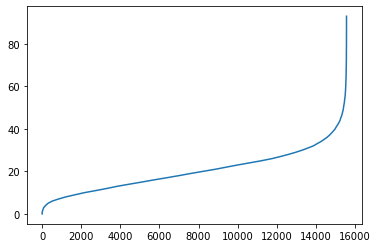

In [333]:
from matplotlib import pyplot
pyplot.plot([np.sum(np.where(num_text<=i,True,False)) for i in range(94)],range(94))

In [349]:
len(np.sort(np.array([len(j.split(" ")) for i in tqdm(df_o["discourse_text"]) for j in i])))

100%|██████████| 15575/15575 [00:00<00:00, 51126.91it/s]


324290

In [358]:
np.sort(np.array([len(j.split(" ")) for i in tqdm(df_o["discourse_text"]) for j in i]))

100%|██████████| 15575/15575 [00:00<00:00, 48944.29it/s]


array([  1,   1,   1, ..., 405, 445, 716])